In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('spotify_songs.csv')

# Display basic info
print(f"Dataset shape: {df.shape}")
print("Columns:", df.columns.tolist())
print("\nSample data:")
print(df.head(3))

Dataset shape: (32833, 23)
Columns: ['track_id', 'track_name', 'track_artist', 'track_popularity', 'track_album_id', 'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

Sample data:
                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   

   track_artist  track_popularity          track_album_id  \
0    Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1      Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2  Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   

                                 

In [26]:
def prepare_collab_data(df):
    """Prepare data for collaborative filtering"""
    # Create user-playlist-song interactions
    interactions = df.groupby(['playlist_id', 'track_id']).size().reset_index(name='count')
    
    # Create numeric indices
    user_ids = interactions['playlist_id'].unique()
    track_ids = interactions['track_id'].unique()
    
    user_id2idx = {o:i for i,o in enumerate(user_ids)}
    track_id2idx = {o:i for i,o in enumerate(track_ids)}
    
    interactions['user_idx'] = interactions['playlist_id'].map(user_id2idx)
    interactions['track_idx'] = interactions['track_id'].map(track_id2idx)
    
    return interactions, user_id2idx, track_id2idx

def build_collab_model(n_users, n_tracks, latent_dim=50):
    """Build collaborative filtering model"""
    # Input layers
    user_input = Input(shape=(1,), name='user_input')
    track_input = Input(shape=(1,), name='track_input')
    
    # Embedding layers
    user_embedding = Embedding(n_users, latent_dim, 
                             embeddings_regularizer=l2(1e-6),
                             name='user_embedding')(user_input)
    track_embedding = Embedding(n_tracks, latent_dim,
                              embeddings_regularizer=l2(1e-6),
                              name='track_embedding')(track_input)
    
    # Dot product of embeddings
    dot_product = Dot(axes=2)([user_embedding, track_embedding])
    output = Flatten()(dot_product)
    
    # Add bias terms
    user_bias = Embedding(n_users, 1)(user_input)
    track_bias = Embedding(n_tracks, 1)(track_input)
    output = output + Flatten()(user_bias) + Flatten()(track_bias)
    
    # Build model
    model = Model(inputs=[user_input, track_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

def train_collab_model():
    """Train collaborative filtering model"""
    # Prepare data
    interactions, user_id2idx, track_id2idx = prepare_collab_data(df)
    
    # Train-test split
    X = interactions[['user_idx', 'track_idx']].values
    y = interactions['count'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Build model
    model = build_collab_model(len(user_id2idx), len(track_id2idx))
    
    # Train
    history = model.fit([X_train[:,0], X_train[:,1]], y_train,
                       batch_size=64,
                       epochs=20,
                       validation_data=([X_test[:,0], X_test[:,1]], y_test))
    
    return model, history, user_id2idx, track_id2idx

In [32]:
def prepare_content_features(df):
    """Prepare audio content features"""
    # Select audio features
    audio_features = ['danceability', 'energy', 'loudness', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    
    # Normalize features
    scaler = MinMaxScaler()
    content_features = pd.DataFrame(scaler.fit_transform(df[audio_features]),
                                  columns=audio_features,
                                  index=df.index)
    
    # Add track_id for merging
    content_features['track_id'] = df['track_id']
    
    return content_features, audio_features

def build_hybrid_model(n_users, n_tracks, n_features, latent_dim=50):
    """Build hybrid recommendation model"""
    # Collaborative inputs
    user_input = Input(shape=(1,), name='user_input')
    track_input = Input(shape=(1,), name='track_input')
    
    # Embedding layers
    user_embedding = Embedding(n_users, latent_dim, 
                             embeddings_regularizer=l2(1e-6))(user_input)
    track_embedding = Embedding(n_tracks, latent_dim,
                              embeddings_regularizer=l2(1e-6))(track_input)
    
    # Content features input
    content_input = Input(shape=(n_features,), name='content_input')
    
    # Dot product of embeddings
    dot_product = Dot(axes=2)([user_embedding, track_embedding])
    dot_product = Flatten()(dot_product)
    
    # Combine with content features
    merged = Concatenate()([dot_product, content_input])
    
    # Add dense layers
    dense = Dense(64, activation='relu')(merged)
    output = Dense(1)(dense)
    
    # Build model
    model = Model(inputs=[user_input, track_input, content_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

def train_hybrid_model():
    """Train hybrid recommendation model"""
    # Prepare collaborative data
    interactions, user_id2idx, track_id2idx = prepare_collab_data(df)
    
    # Prepare content features
    content_features, audio_features = prepare_content_features(df)
    
    # Merge interactions with content features
    merged = interactions.merge(content_features, on='track_id')
    
    # Train-test split
    X = merged[['user_idx', 'track_idx'] + audio_features]
    y = merged['count'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Build model
    model = build_hybrid_model(len(user_id2idx), len(track_id2idx), len(audio_features))
    
    # Train
    history = model.fit([X_train['user_idx'], X_train['track_idx'], X_train[audio_features]], y_train,
                       batch_size=64,
                       epochs=20,
                       validation_data=([X_test['user_idx'], X_test['track_idx'], X_test[audio_features]], y_test))
    track_features_dict = {
    row['track_id']: row[audio_features].values
    for _, row in df.iterrows()
    }
    
    return model, history, user_id2idx, track_id2idx, audio_features, track_features_dict


In [34]:
import numpy as np
import pandas as pd

def generate_recommendations(
    model,
    user_id,
    user_id2idx,
    track_id2idx,
    df,
    n=10,
    hybrid=False,
    audio_features=None
):
    if user_id not in user_id2idx:
        print(f"User ID {user_id} not found.")
        return pd.DataFrame()

    user_idx = user_id2idx[user_id]
    user_array = np.full(len(track_id2idx), user_idx)

    # Get valid track IDs that exist in mapping
    valid_track_ids = [tid for tid in track_id2idx if tid in df['track_id'].values]
    valid_indices = [track_id2idx[tid] for tid in valid_track_ids]
    valid_indices = np.array(valid_indices, dtype=np.int32)

    if hybrid and audio_features is not None:
        # Make sure every track_id has a feature vector
        filtered_track_ids = [tid for tid in valid_track_ids if tid in audio_features]

        # Update indices based on filtered track_ids
        valid_indices = np.array([track_id2idx[tid] for tid in filtered_track_ids])
        user_array = np.full(len(filtered_track_ids), user_idx)

        # Stack feature vectors into a clean 2D array
        track_features = np.stack([
            np.array(audio_features[tid], dtype=np.float32) for tid in filtered_track_ids
        ])

        predictions = model.predict([user_array, valid_indices, track_features], verbose=0).flatten()
        top_indices = np.argsort(predictions)[::-1][:n]
        top_track_ids = [filtered_track_ids[i] for i in top_indices]

    else:
        predictions = model.predict([user_array, valid_indices], verbose=0).flatten()
        top_indices = np.argsort(predictions)[::-1][:n]
        top_track_ids = [valid_track_ids[i] for i in top_indices]

    # Pull info from original df
    recommended_tracks = df[df['track_id'].isin(top_track_ids)][[
        'track_name', 'track_artist', 'track_id'
    ]].drop_duplicates()

    return recommended_tracks




def evaluate_model(model, X_test, y_test, hybrid=False, audio_features=None):
    """Evaluate model performance"""
    if hybrid:
        test_loss, test_mae = model.evaluate(
            [X_test['user_idx'], X_test['track_idx'], X_test[audio_features]], 
            y_test, verbose=0)
    else:
        test_loss, test_mae = model.evaluate(
            [X_test['user_idx'], X_test['track_idx']], 
            y_test, verbose=0)
    
    print(f"Test Loss (MSE): {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

Training Collaborative Filtering Model...
Epoch 1/20
404/404 [==============================] - 5s 9ms/step - loss: 0.9245 - mae: 0.9483 - val_loss: 0.7788 - val_mae: 0.8717
Epoch 2/20
404/404 [==============================] - 4s 9ms/step - loss: 0.5955 - mae: 0.7538 - val_loss: 0.5695 - val_mae: 0.7409
Epoch 3/20
404/404 [==============================] - 4s 9ms/step - loss: 0.2012 - mae: 0.4082 - val_loss: 0.4498 - val_mae: 0.6515
Epoch 4/20
404/404 [==============================] - 3s 8ms/step - loss: 0.0242 - mae: 0.0803 - val_loss: 0.4332 - val_mae: 0.6385
Epoch 5/20
404/404 [==============================] - 4s 9ms/step - loss: 0.0078 - mae: 0.0254 - val_loss: 0.4301 - val_mae: 0.6364
Epoch 6/20
404/404 [==============================] - 4s 9ms/step - loss: 0.0056 - mae: 0.0147 - val_loss: 0.4278 - val_mae: 0.6346
Epoch 7/20
404/404 [==============================] - 3s 8ms/step - loss: 0.0053 - mae: 0.0136 - val_loss: 0.4250 - val_mae: 0.6324
Epoch 8/20
404/404 [==============

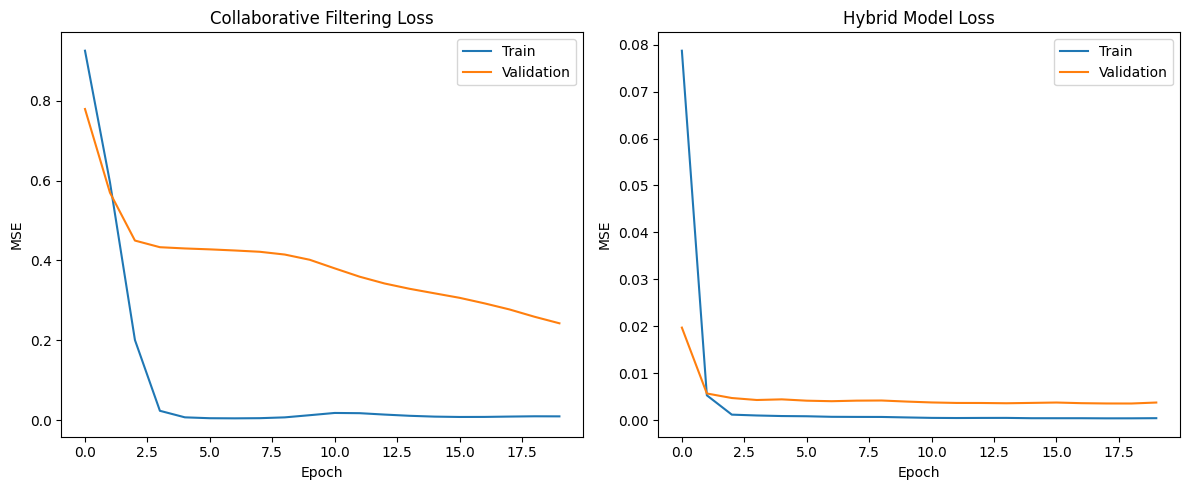


Collaborative Filtering Evaluation:
Test Loss (MSE): 0.2430
Test MAE: 0.4653

Hybrid Model Evaluation:
Test Loss (MSE): 0.0037
Test MAE: 0.0132

Recommendations for playlist 0275i1VNfBnsNbPl0QIBpG:

Collaborative Filtering Recommendations:
                  track_name               track_artist  \
7886  All Girls Are The Same                 Juice WRLD   
7888          Truffle Butter                Nicki Minaj   
7895         Erase Me - Main                   Kid Cudi   
7898               Lost Ones                    J. Cole   
7905               How We Do                   The Game   
7922                No Sleep                Wiz Khalifa   
7945              Een Barkie  De Jeugd Van Tegenwoordig   
7948              If I Can't                    50 Cent   
7949               We Zijn 1                      Winne   
7965             Mockingbird                     Eminem   

                    track_id  
7886  1dNyRyz1QBN9kO1etUs1PI  
7888  3keUgTGEoZJt0QkzTB6kHg  
7895  1ToNAInnkl

In [35]:
def main():
    print("Training Collaborative Filtering Model...")
    collab_model, collab_history, user_id2idx, track_id2idx = train_collab_model()

    print("\nTraining Hybrid Model...")
    hybrid_model, hybrid_history, _, _, audio_features, track_features_dict = train_hybrid_model()

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(collab_history.history['loss'], label='Train')
    plt.plot(collab_history.history['val_loss'], label='Validation')
    plt.title('Collaborative Filtering Loss')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hybrid_history.history['loss'], label='Train')
    plt.plot(hybrid_history.history['val_loss'], label='Validation')
    plt.title('Hybrid Model Loss')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate models
    print("\nCollaborative Filtering Evaluation:")
    interactions, _, _ = prepare_collab_data(df)
    X_collab = interactions[['user_idx', 'track_idx']]
    y_collab = interactions['count']
    _, X_test_collab, _, y_test_collab = train_test_split(X_collab, y_collab, test_size=0.2, random_state=42)
    evaluate_model(collab_model, X_test_collab, y_test_collab)

    print("\nHybrid Model Evaluation:")
    content_features, _ = prepare_content_features(df)
    merged = interactions.merge(content_features, on='track_id')
    X_hybrid = merged[['user_idx', 'track_idx'] + audio_features]
    y_hybrid = merged['count']
    _, X_test_hybrid, _, y_test_hybrid = train_test_split(X_hybrid, y_hybrid, test_size=0.2, random_state=42)
    evaluate_model(hybrid_model, X_test_hybrid, y_test_hybrid, hybrid=True, audio_features=audio_features)

    # Generate recommendations
    sample_user = next(iter(user_id2idx.keys()))
    print(f"\nRecommendations for playlist {sample_user}:")

    print("\nCollaborative Filtering Recommendations:")
    collab_recs = generate_recommendations(
        collab_model,
        user_id=sample_user,
        user_id2idx=user_id2idx,
        track_id2idx=track_id2idx,
        df=df
    )
    print(collab_recs.head(10))

    print("\nHybrid Recommendations:")
    hybrid_recs = generate_recommendations(
        hybrid_model,
        user_id=sample_user,
        user_id2idx=user_id2idx,
        track_id2idx=track_id2idx,
        df=df,
        hybrid=True,
        audio_features=track_features_dict  # ✅ Use the dict here
    )
    print(hybrid_recs.head(10))

if __name__ == "__main__":
    main()


https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs?select=spotify_songs.csv